# Import Required Packages

In [ ]:
#Data and visualization libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ML libraries
import tensorflow as tf
import tensorflow.keras as keras
from sklearn import metrics
from sklearn import preprocessing

# Inline figures
%matplotlib inline

# Figure aesthetics
sns.set(context='notebook', style='white', font_scale=1.2)
sns.set_style('ticks', {'xtick.direction':'in', 'ytick.direction':'in'})

# Dataset

Transformer diagnostic tests are described in terms of the following six parameters:
* Water (ppm)
* Acidity (mgKOH/g)
* DBV (kV)
* Dissipation factor (%)
* TDCG (ppm)
* Furan (mg/L)

with following meaning: water content in the transformer oil in ppm (Water), total acidity of the oil in mgKOH/g (Acidity), dissolved combustible gases in ppm (TDCG), oil breakdown voltage in kV (DBV), dissipation factor in percent (DF), and 2-Furfuraldehyde content in mg/L (Furan).

In [ ]:
#Load data
data = pd.read_csv('Health_index.csv')
data.drop(labels=['No.', 'AMHA-S', 'AMHA', 'Fuzzy-S', 'Fuzzy', 'LogReg-S', 'LogReg'], axis=1, inplace=True)

#EDA

In [ ]:
#Count of categories in target variable
data['GRNN'].value_counts()/data['GRNN'].value_counts().sum()

VG    0.300000
G     0.233333
B     0.200000
M     0.166667
VB    0.100000
Name: GRNN, dtype: float64

In [ ]:
# Correcting outlier with the median value of the data
median = np.percentile(data['DF'], q=50)
data.at[18, 'DF']=median
data.iloc[17:20]

,Water,Acidity,DBV,DF,TDCG,Furan,GRNN-S,GRNN
17,23.6,0.070,39.2,0.203,22,0.50,0.406,G
18,30.5,0.073,28.7,0.205,30,1.70,0.790,B
19,18.4,0.063,64.5,0.243,69,0.15,0.119,VG


In [ ]:
# Column names
values = ['Water', 'Acidity', 'DBV', 'DF', 'TDCG', 'Furan']
values_all = ['Water', 'Acidity', 'DBV', 'DF', 'TDCG', 'Furan', 'GRNN-S']

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:1152: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))


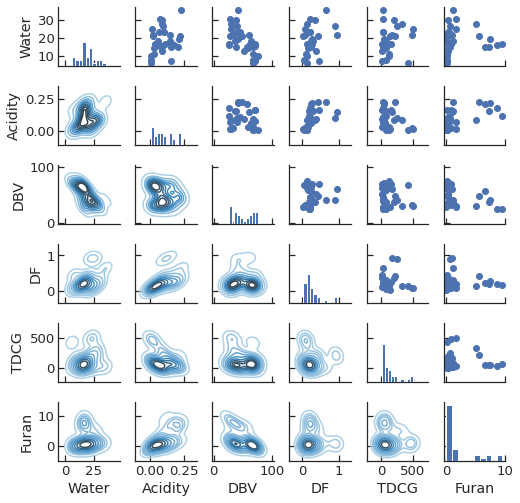

In [ ]:
#Visualize the features
g = sns.PairGrid(data[values], size=1.2)  # size in inches?!
g.map_upper(plt.scatter);
g.map_lower(sns.kdeplot, cmap='Blues_d');
g.map_diag(plt.hist);

### Pearson's correlation matrix (Predictivity)

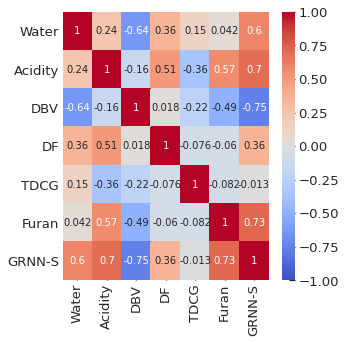

In [ ]:
# Predictivity (Pearson correlation matrix)
pearson = data[values_all].corr('pearson')
# Correlation matrix as heatmap (seaborn)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(pearson, annot=True, annot_kws=dict(size=10), vmin=-1, vmax=1, cmap=plt.cm.coolwarm, ax=ax)
plt.tight_layout()
plt.show()

#Data Preprocessing

##Generate syntetic transformer data

In [ ]:
# Generate synthetic data using the "data augmentation" technique
def trafo_measurements(df, num=100, fraction=0.1):
    data = {}
    idxmax = len(df.index)
    ranvals = np.random.randint(low=0, high=idxmax, size=num)
    for name in df.columns:
        if name == 'GRNN-S':
            data[name] = df[name].iloc[ranvals]
        else:
            sd = df[name].std()
            datavals = df[name].iloc[ranvals].values
            ransigns = np.random.choice([-1., 1.], size=num, replace=True)
            synvalues = datavals + ransigns*(sd*fraction)
            values = np.empty_like(synvalues)
            for i, val in enumerate(synvalues):
                if val > 0. or val is not np.NaN:
                    values[i] = val
                else:
                    values[i] = datavals[i]
            data[name] = np.round(values, decimals=3)
    data = pd.DataFrame(data, columns=df.columns)
    return data

Health Index values:
VB = 4 -> Very bad
 B = 3 -> Bad
 M = 2 -> Moderate
 G = 1 -> Good
VG = 0 -> Very good 

In [ ]:
def from_descr_to_score(description):
    if description == 'VB':
        score = 4
    elif description == 'B':
        score = 3
    elif description == 'M':
        score = 2
    elif description == 'G':
        score = 1
    elif description == 'VG':
        score = 0
    else:
        score = None
        raise ValueError('Invalid class label {} encountered!'.format(description))
    return score

def from_score_to_descr(score):
    if score <= 0.2:
        description = 'VG'
    elif 0.2 < score <= 0.4:
        description = 'G'
    elif 0.4 < score <= 0.6:
        description = 'M'
    elif 0.6 < score <= 0.8:
        description = 'B'
    elif 0.8 < score:
        description = 'VB'
    else:
        description = None
        raise ValueError('Score value {} is outside the intended range [0-1]!'.format(score))
    return description

def from_class_to_label(cl):
    if cl == 4:
        label = 'VB'
    elif cl == 3:
        label = 'B'
    elif cl == 2:
        label = 'M'
    elif cl == 1:
        label = 'G'
    elif cl == 0:
        label = 'VG'
    else:
        label = None
        raise ValueError('Invalid class index {} encountered!'.format(cl))
    return label

In [ ]:
def heatmap(values, xlabel, ylabel, xticklabels, yticklabels, cmap=None,
            vmin=None, vmax=None, ax=None, fmt="%0.2f"):
    if ax is None:
        ax = plt.gca()
    # plot the mean cross-validation scores
    img = ax.pcolor(values, cmap=cmap, vmin=vmin, vmax=vmax)
    img.update_scalarmappable()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticks(np.arange(len(xticklabels)) + .5)
    ax.set_yticks(np.arange(len(yticklabels)) + .5)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.set_aspect(1)

    for p, color, value in zip(img.get_paths(), img.get_facecolors(),
                               img.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.mean(color[:3]) > 0.5:
            c = 'k'
        else:
            c = 'w'
        ax.text(x, y, fmt % value, color=c, ha="center", va="center")
    return img

In [ ]:
# Generate syntetic data using "data augmentation"
syntetic = trafo_measurements(data[values_all], num=100)
syntetic['GRNN'] = syntetic['GRNN-S'].apply(from_score_to_descr)

In [ ]:
data['score'] = data['GRNN'].apply(from_descr_to_score)
syntetic['score'] = syntetic['GRNN'].apply(from_descr_to_score)
syntetic.head()

,Water,Acidity,DBV,DF,TDCG,Furan,GRNN-S,GRNN,score
14,26.889,0.096,28.767,0.106,321.948,4.82,0.700,B,3
23,5.289,0.003,69.233,0.148,441.052,-0.22,0.015,VG,0
25,11.811,0.025,68.833,0.111,104.948,0.34,0.010,VG,0
24,17.689,0.159,38.833,0.321,95.052,1.44,0.550,M,2
27,6.789,0.153,71.733,0.470,24.052,0.36,0.314,G,1


##More EDA

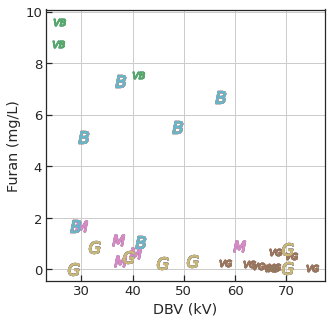

In [ ]:
# original transformer data using only two features
plt.figure(figsize=(5,5))
for outcome in data['score'].values:
    plt.scatter(data[data.score == outcome].DBV, data[data.score == outcome].Furan, 
                s=150, marker='${}$'.format(from_class_to_label(outcome)))
plt.grid()
plt.xlabel('DBV (kV)')
plt.ylabel('Furan (mg/L)')
plt.show()

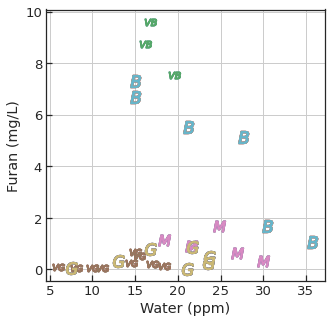

In [ ]:
# original transformer data using only two features
plt.figure(figsize=(5,5))
for outcome in data['score'].values:
    plt.scatter(data[data.score == outcome].Water, data[data.score == outcome].Furan, 
                s=150, marker='${}$'.format(from_class_to_label(outcome)))
plt.grid()
plt.xlabel('Water (ppm)')
plt.ylabel('Furan (mg/L)')
plt.show()

## Data Normalization and splitting

In [ ]:
y_t = data[['GRNN']].copy()  # instantiate dataframe for comparisons

In [ ]:
# Train data (synthetic)
X_train = syntetic[values]
y_train = syntetic['score'].values
# Test data (actual)
X_test = data[values]
y_test = data['score'].values

In [ ]:
# Standardize the input data
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#ANN Model

##Design

In [ ]:
# Encode 'targets' to categorical variables
y_train_nn = keras.utils.to_categorical(y_train)
y_test_nn = keras.utils.to_categorical(y_test)

In [ ]:
# Keras: Feed-forward artificial neural network
model = keras.models.Sequential()
# Input layer
model.add(keras.layers.Dense(units=64, activation='relu', input_dim=X_train.shape[1]))
model.add(keras.layers.Dropout(0.5))  # regularization layer
# hidden layer
model.add(keras.layers.Dense(units=64, activation='tanh'))
model.add(keras.layers.Dropout(0.5))
# hidden layer
model.add(keras.layers.Dense(units=32, activation='tanh'))
# *** Add additional hidden layers here ***
# Output layer
# Following line defines Softmax Regression (un-ordered categories)
model.add(keras.layers.Dense(units=5, activation='softmax'))
# Optimizer
adam = keras.optimizers.Adam()
# Compile network
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

##Training

In [ ]:
BATCH = 32     # 'batch_size' argument
EPOCHS = 200   # 'epochs' argument

In [ ]:
# Fit model on train data
history = model.fit(X_train, y_train_nn, epochs=EPOCHS, batch_size=BATCH, 
                    validation_data=(X_test, y_test_nn), shuffle=True, verbose=1)
# Score metrics (evaluate model on test data)
score = model.evaluate(X_test, y_test_nn, batch_size=BATCH, verbose=0)
print('Log-loss: {:g}, Accuracy: {:.2f} %'.format(score[0], score[1]*100))

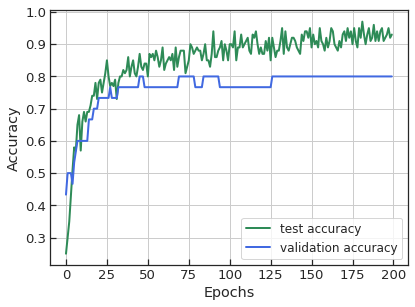

In [ ]:
#Visualize training history
hist = history.history
acc = hist['accuracy']
acc_val = hist['val_accuracy']
fig, ax = plt.subplots(figsize=(6,4.5))
ax.plot(acc, ls='-', lw=2, c='seagreen', label='test accuracy')
ax.plot(acc_val, ls='-', lw=2, c='royalblue', label='validation accuracy')
ax.grid()
ax.legend(loc='best', fontsize=12)
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
plt.tight_layout()
plt.show()

##Model Prediction

In [ ]:
# Predict class probability on test data
y_pred_proba_nn = model.predict_proba(X_test, batch_size=BATCH, verbose=0)
y_t['k'] = y_pred_proba_nn.argmax(axis=1)
y_t['keras'] = y_t['k'].apply(from_class_to_label)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


##Model Evaluation

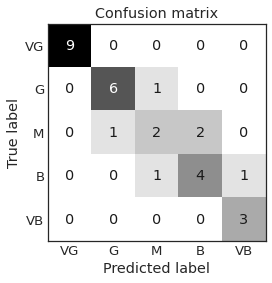

In [ ]:
# confusion matrix for ANN predictions
labels = ['VG', 'G', 'M', 'B', 'VB']
scores_image = heatmap(metrics.confusion_matrix(y_test, y_t['k'].values), 
                       xlabel='Predicted label', ylabel='True label', 
                       xticklabels=labels, yticklabels=labels, 
                       cmap=plt.cm.gray_r, fmt="%d")
del y_t['k']
plt.title("Confusion matrix")
plt.gca().invert_yaxis()
plt.show()